# Chapter 1: Data Acquisition
In this section, we connect to the raw Titanic dataset hosted on GitHub. To keep the project environment "light" and avoid local file management, we pull the data directly into memory using a public URL.

### Key Tools:
* **Pandas**: For data manipulation and analysis.
* **Seaborn/Matplotlib**: For statistical data visualization.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# We use the direct URL instead of a local file path
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

# Look at the first 5 passengers
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Chapter 2: Data Integrity Check
Before performing any analysis, we must understand the "Vital Signs" of our dataset. We use `df.info()` to inspect the data types and, more importantly, to identify **Missing Values (Nulls)**.

### Observations to look for:
1. **Total Entries**: 891 passengers.
2. **Missing Ages**: The 'Age' column is incomplete and will require **Imputation** (filling in the gaps).
3. **Missing Cabin Info**: The 'Cabin' column is mostly empty and may need to be dropped.

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    str    
 4   Sex          891 non-null    str    
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    str    
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    str    
 11  Embarked     889 non-null    str    
dtypes: float64(2), int64(5), str(5)
memory usage: 83.7 KB


> **Output Analysis & Imputation Strategy:** > 
> * **Age**: Initially, the 'Age' column had only 714 non-null values (~20% missing). We have resolved this by **Median Imputation**, ensuring our model has a complete dataset without the bias of extreme age outliers.
> 
> * **Embarked**: With only 2 values missing, we used **Mode Imputation** (filling with 'S'), as it is the most statistically likely port of origin.
> 
> * **Cabin**: This feature was missing over **77%** of its data. Rather than guessing cabin numbers, we transformed this into a binary feature **'HasCabin'**. This captures the potential survival advantage of having an assigned room versus being in general steerage, while effectively "neutralizing" the missing data problem.

# Chapter 3: Exploratory Data Analysis (EDA)
In this phase, we look for visual evidence of "Survival Drivers." We want to see which features (like Gender or Social Class) have the strongest correlation with survival. 

### Why Visualize?
Machine Learning models are only as good as the patterns we provide. By plotting these relationships, we can confirm our intuition before building the model.

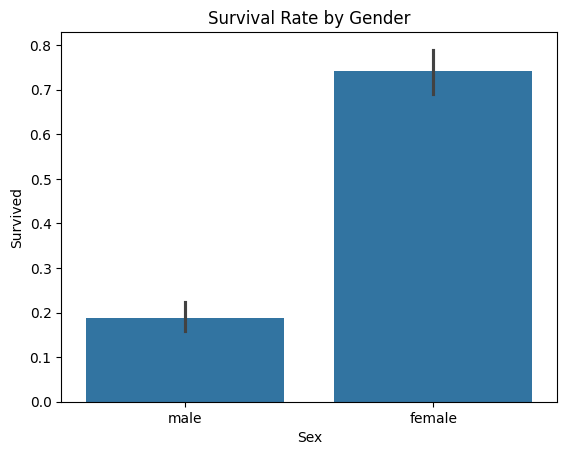

In [4]:
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival Rate by Gender')

plt.show()

### Survival Analysis by Age Group (Binning)

To better understand the relationship between age and survival, we have "binned" the continuous Age data into discrete life stages: Child, Teen, Young Adult, Adult, and Senior.

By grouping ages, we can more clearly observe the "Women and Children First" protocol in action.

Why we use Binning here:

    Noise Reduction: Individual ages (like 21 vs. 22) often have no statistical difference in survival. Binning smooths out this "noise."

    Pattern Recognition: It becomes immediately obvious if infants or the elderly were prioritized during the evacuation.

    Gap Management: This view helps us see how our "Imputed" (filled-in) ages fit into the broader distribution of the passenger manifest.

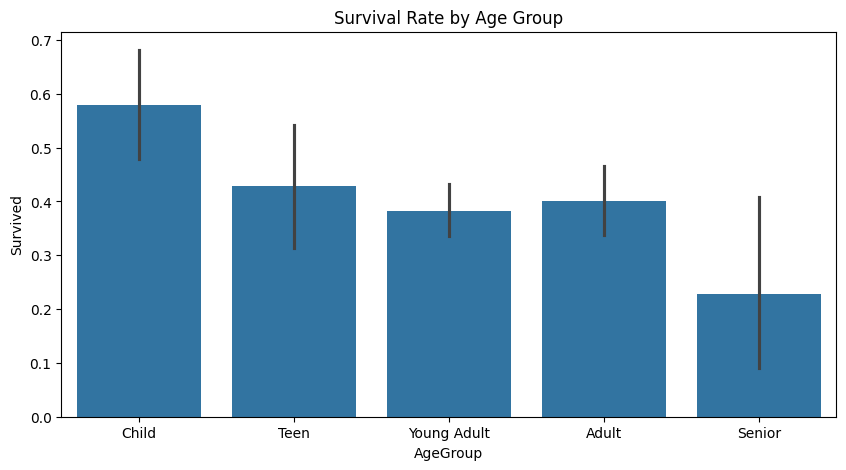

In [5]:
# Create age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 80], 
                        labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])

plt.figure(figsize=(10, 5))
sns.barplot(x='AgeGroup', y='Survived', data=df)
plt.title('Survival Rate by Age Group')
plt.show()


### Handling Missing Data (Imputation & Feature Engineering)

Upon inspection, we identified three columns with missing values. Our strategy for each is tailored to the amount of data missing and the nature of the feature:

*   **Age (177 missing values ~20%):** We perform Median Imputation.
    *   **Why Median?:** The age distribution is slightly skewed; the median provides a more robust "middle" value than the mean (average), which can be pulled by outliers.

*   **Embarked (2 missing values):** We use Mode Imputation (filling with 'S').
    *   **Why Mode?:** Since this is categorical data with very few missing entries, we fill the "holes" with the most frequent port of embarkation (Southampton).

*   **Cabin (687 missing values ~77%):** Due to the massive amount of missing data, standard imputation would be inaccurate. Instead, we use Feature Engineering to create a new binary feature: `HasCabin`.
    *   **Why binary?:** We assume that simply having a recorded cabin number might be a proxy for higher social status and better survival odds. We assign `1` if a cabin is listed and `0` if it is missing.


In [21]:
# 1. Fill missing Age values
df['Age'] = df['Age'].fillna(df['Age'].median())

# 2. Fill missing Embarked values
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 3. Handle the Cabin column
# We create a 'HasCabin' feature: 1 if they had a cabin, 0 if it's missing (NaN)
df['HasCabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

# Verify the "Holes" are gone in our target columns
print("Missing values after filling:")
print(df[['Age', 'Embarked', 'HasCabin']].isnull().sum())

Missing values after filling:
Age         0
Embarked    0
HasCabin    0
dtype: int64


### Categorical Encoding: One-Hot Encoding
The 'Embarked' column contains non-numeric data representing the port of departure. Since there is no inherent "rank" between these ports, we use **One-Hot Encoding**. This creates a new binary column (0 or 1) for each unique port, ensuring the model treats them as distinct categories without a mathematical hierarchy.

In [ ]:
# Using Pandas' get_dummies to create the 0/1 columns
embarked_dummy = pd.get_dummies(df['Embarked'], prefix='Port')

# Combining the new dummy columns with the original DataFrame
df = pd.concat([df, embarked_dummy], axis=1)

# Looking at the new columns at the front of the DataFrame
df.filter(like='Port').head()

,Port_C,Port_Q,Port_S,Port_C,Port_Q,Port_S
0,False,False,True,False,False,True
1,True,False,False,True,False,False
2,False,False,True,False,False,True
3,False,False,True,False,False,True
4,False,False,True,False,False,True


### 7. Feature Scaling (Standardization)
Machine Learning algorithms like Logistic Regression and Support Vector Machines are sensitive to the scale of the input data. Currently, 'Fare' has a much wider range than 'Age'. 

We use **Standardization** to transform these features so they have a mean of 0 and a standard deviation of 1. This ensures that the model treats all features with equal importance during the optimization process.

In [ ]:
# Create FamilySize feature by combining SibSp(siblings/spouses) and Parch(parents/children)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [ ]:
from sklearn.preprocessing import StandardScaler

# initialize the scaler
scaler = StandardScaler()

# columns with different scales to be standardized
cols_to_scale = ['Age', 'Fare', 'FamilySize']

# fit and transform the data it will standardize the selected columns by removing the mean and scaling to unit variance
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# display the first 5 rows of the standardized columns
df[cols_to_scale].head()

,Age,Fare,FamilySize
0,-0.530377,-0.502445,0.059160
1,0.571831,0.786845,0.059160
2,-0.254825,-0.488854,-0.560975
3,0.365167,0.420730,0.059160
4,0.365167,-0.486337,-0.560975


In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 1. Initialize the three scalers
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
rb_scaler = RobustScaler()

# 2. Apply them to the 'Fare' column
# We use .values.reshape(-1, 1) because scalers expect a 2D array
fare_data = df[['Fare']]

df['Fare_Standard'] = std_scaler.fit_transform(fare_data)
df['Fare_MinMax'] = mm_scaler.fit_transform(fare_data)
df['Fare_Robust'] = rb_scaler.fit_transform(fare_data)

# 3. Compare the stats
comparison = df[['Fare', 'Fare_Standard', 'Fare_MinMax', 'Fare_Robust']].describe().round(3)
print(comparison)

          Fare  Fare_Standard  Fare_MinMax  Fare_Robust
count  891.000        891.000      891.000      891.000
mean     0.000          0.000        0.063        0.769
std      1.001          1.001        0.097        2.152
min     -0.648         -0.648        0.000       -0.626
25%     -0.489         -0.489        0.015       -0.283
50%     -0.357         -0.357        0.028        0.000
75%     -0.024         -0.024        0.061        0.717
max      9.667          9.667        1.000       21.563


To ensure our model treats all numerical features (Age, Fare, FamilySize) fairly, we must scale them. While we used **StandardScaler** for its general-purpose reliability, we also considered:

* **StandardScaler**: Centers data around a mean of 0. We chose this for our final model as it is the standard for Logistic Regression.
* **MinMaxScaler**: Ideal for squashing data into a 0 to 1 range, though sensitive to outliers.
* **RobustScaler**: Best for data with extreme outliers, as it uses the Median instead of the Mean.

#### The "Golden Rule" of Scaling: Fit vs. Transform
To prevent **Data Leakage** (the model accidentally "cheating" by seeing future data trends), we follow a strict sequence:

1.  **`.fit()`**: The scaler "learns" the parameters (like Mean and Std) from the **Training Data** only.
2.  **`.transform()`**: The scaler applies those learned parameters to any data (Training, Testing, or New).
3.  **`.fit_transform()`**: A convenience method used **only** on the initial training set to learn and apply in one step.

> **Note:** We never `fit` on our Test data. We want the model to treat the Test data as "the unknown future," using only what it learned from the past (the Training set).

### 8. Final Feature Refinement
To maximize model performance, we perform two final preprocessing steps:

1. **Feature Engineering (IsAlone)**: We create a binary feature to distinguish between solo travelers and those with family, as this often correlates with survival priority.
2. **Dimensionality Reduction**: We drop "Noise" columns like `Name`, `Ticket`, and `PassengerId`. These features contain high cardinality or random data that could lead to **Overfitting** (the model memorizing names instead of learning patterns).

In [19]:
# 1. Create the IsAlone feature
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1 
# Note: Use the original family size before you scaled it!

df['Sex_binary'] = df['Sex'].map({'male': 0, 'female': 1})

# 2. Select ONLY the features the AI will use
final_features = [
    'Survived',    # Target
    'Pclass',      # Social Class
    'Sex_binary',  # Gender (0 or 1)
    'Age',         # Scaled Age
    'Fare',        # Scaled Fare
    'FamilySize',  # Scaled Family Size
    'IsAlone',     # Binary (0 or 1)
    'Port_S', 'Port_C', 'Port_Q' # Encoded Ports
]

df_final = df[final_features]

# 3. Final Check: Ensure NO missing values remain
print(df_final.isnull().sum())

Survived      0
Pclass        0
Sex_binary    0
Age           0
Fare          0
FamilySize    0
IsAlone       0
Port_S        0
Port_S        0
Port_C        0
Port_C        0
Port_Q        0
Port_Q        0
dtype: int64
